In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [43]:

class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, 1:].values
        self.X = self.X.reshape(-1,1, 28, 28).astype(np.float32)/255
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y


In [44]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [46]:
class VAE(nn.Module):
    def __init__(self, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(latent_dim, 20)
        self.logvar_layer = nn.Linear(latent_dim, 20)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(), 
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        std = torch.exp(0.5 * var) 
        epsilon = torch.randn_like(std).to(device)
        z = mean + std*epsilon
        return z

    def decode(self, x):
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterization(mu, logvar)
        recon_x = self.decode(z)
        recon_x = recon_x.view(-1, 1, 28, 28)

        return recon_x, mu, logvar

In [47]:
def loss_function(x, recon_x, mean, log_var):
    reproduction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [48]:
def model_training(model, optimizer, epochs=50):
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            recon_images, mu, logvar = model(images)
            loss = loss_function(images, recon_images, mu, logvar)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        avg_train_loss = total_train_loss/len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                test_recon_images, test_mu, test_logvar = model(images)
                loss = loss_function(images,test_recon_images, test_mu, test_logvar)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss/len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")

                
    return train_losses, test_losses

In [49]:
model = VAE(hidden_dim=400, latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, test_losses = model_training(model, optimizer, epochs=50)

Epoch 1/50 | Train Loss: 5436.6326 | Test Loss: 4559.3346
Epoch 2/50 | Train Loss: 4306.6239 | Test Loss: 4089.1240
Epoch 3/50 | Train Loss: 4018.4707 | Test Loss: 3922.1795
Epoch 4/50 | Train Loss: 3882.9593 | Test Loss: 3831.0898
Epoch 5/50 | Train Loss: 3797.1479 | Test Loss: 3733.6781
Epoch 6/50 | Train Loss: 3728.7285 | Test Loss: 3694.1403
Epoch 7/50 | Train Loss: 3679.3259 | Test Loss: 3656.6661
Epoch 8/50 | Train Loss: 3644.4484 | Test Loss: 3626.5437
Epoch 9/50 | Train Loss: 3614.3324 | Test Loss: 3627.9325
Epoch 10/50 | Train Loss: 3592.3716 | Test Loss: 3577.1715
Epoch 11/50 | Train Loss: 3572.2732 | Test Loss: 3562.5703
Epoch 12/50 | Train Loss: 3557.8600 | Test Loss: 3551.9136
Epoch 13/50 | Train Loss: 3542.2757 | Test Loss: 3549.3457
Epoch 14/50 | Train Loss: 3529.1859 | Test Loss: 3548.7348
Epoch 15/50 | Train Loss: 3516.9022 | Test Loss: 3540.7168
Epoch 16/50 | Train Loss: 3507.7411 | Test Loss: 3516.3495
Epoch 17/50 | Train Loss: 3494.9942 | Test Loss: 3514.2879
Epoch 

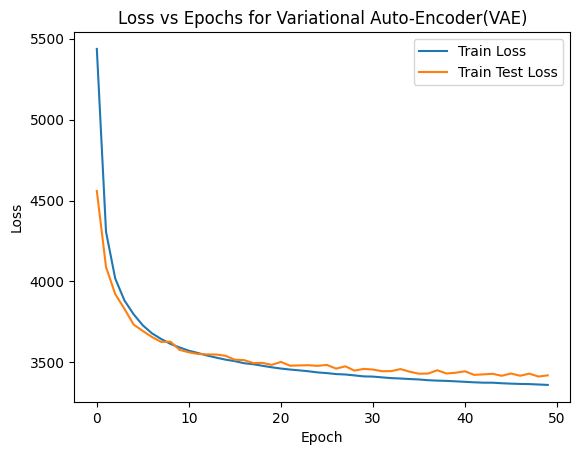

In [50]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Train Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Variational Auto-Encoder(VAE)")
plt.legend()
plt.show()

In [56]:
model.eval()

data_iter = iter(test_loader)

with torch.no_grad():
    images, _ = next(data_iter)
    image = images[0].unsqueeze(0).to(device)
    recon_images, mu, logvar = model(image)

    z = model.reparameterization(mu, logvar)


def vary_latent_dimension(z, dim_idx, model, steps=10, range_min = -3, range_max = 3):
    z = z.clone().detach()
    variations = []
    linspace = torch.linspace(range_min, range_max, steps).to(device)

    for val in linspace:
        new_z = z.clone()
        new_z[0, dim_idx] = val
        with torch.no_grad():
            generated = model.decode(new_z)
            generated  = generated.view(28, 28).cpu().numpy()
        variations.append(generated)
    return variations


def plot_variations(variations, title):
    fig, axes = plt.subplots(1, len(variations), figsize=(15,2))

    for i, img in enumerate(variations):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

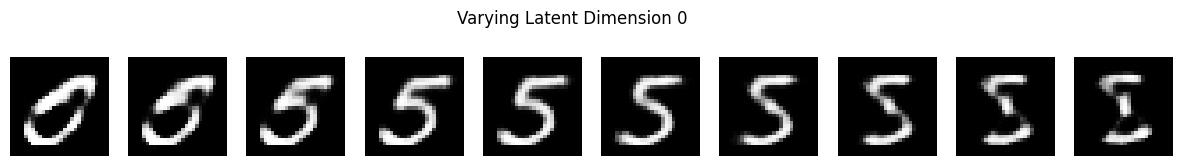

In [57]:
variations = vary_latent_dimension(z, dim_idx=0, model=model)
plot_variations(variations, title='Varying Latent Dimension 0')

In [58]:
threshold = 0.05

inactive_dims = []

for dim in range(z.size(1)):
    variations = vary_latent_dimension(z, dim_idx = dim, model=model)

    diff = np.abs(variations[0]-variations[-1]).mean()

    print(f"Dimension {dim}: Difference = {diff:.4f}")
    if diff < threshold:
        inactive_dims.append(dim)

print(f"Inactive dimensions (no effect): {inactive_dims}")

Dimension 0: Difference = 0.2047
Dimension 1: Difference = 0.1420
Dimension 2: Difference = 0.1232
Dimension 3: Difference = 0.0059
Dimension 4: Difference = 0.0043
Dimension 5: Difference = 0.0061
Dimension 6: Difference = 0.0062
Dimension 7: Difference = 0.0047
Dimension 8: Difference = 0.1221
Dimension 9: Difference = 0.0058
Dimension 10: Difference = 0.2166
Dimension 11: Difference = 0.1775
Dimension 12: Difference = 0.2068
Dimension 13: Difference = 0.0064
Dimension 14: Difference = 0.0064
Dimension 15: Difference = 0.0058
Dimension 16: Difference = 0.1566
Dimension 17: Difference = 0.1295
Dimension 18: Difference = 0.2346
Dimension 19: Difference = 0.0982
Inactive dimensions (no effect): [3, 4, 5, 6, 7, 9, 13, 14, 15]


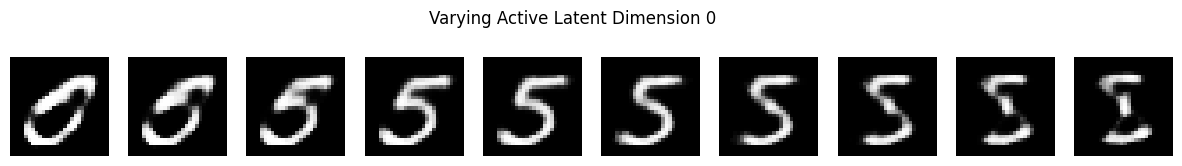

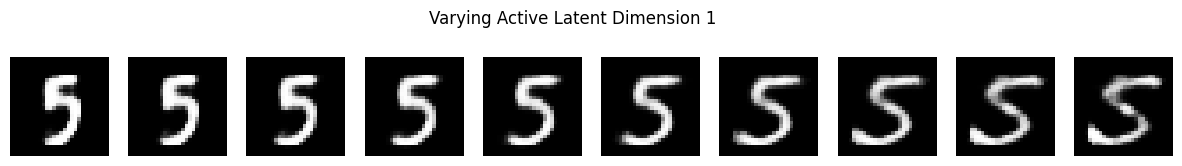

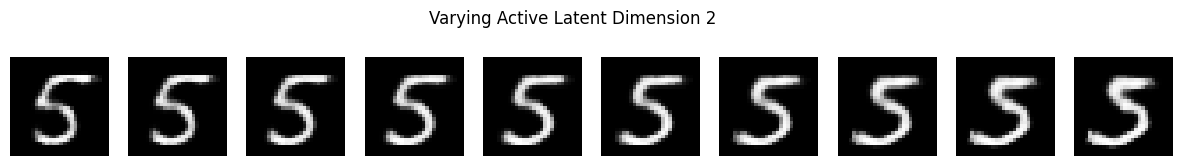

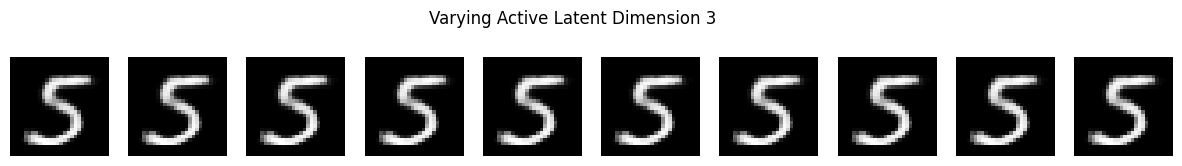

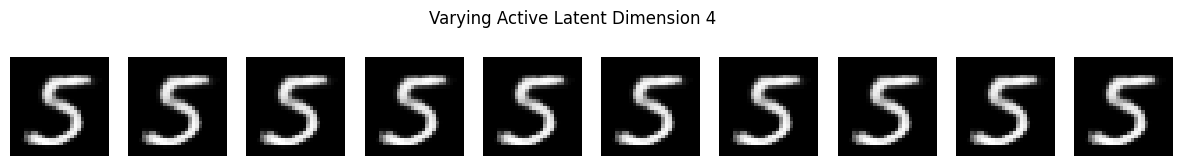

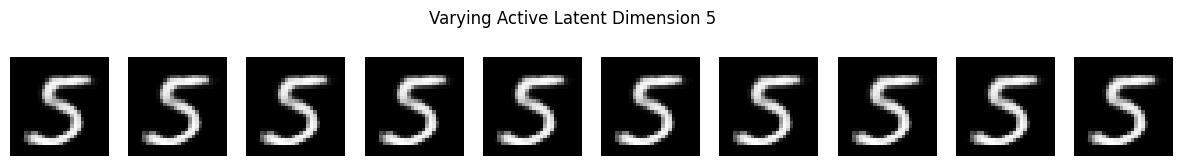

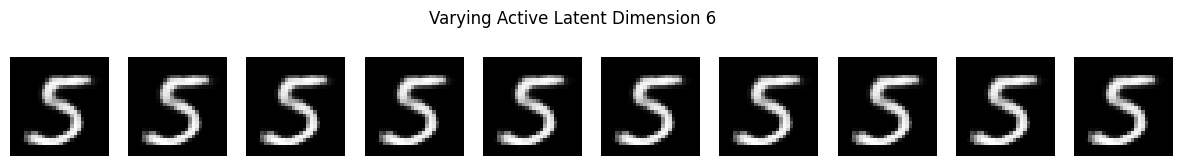

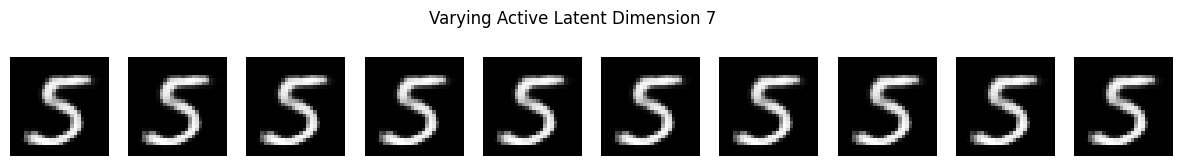

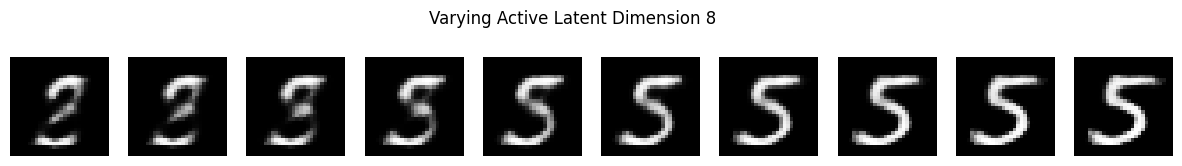

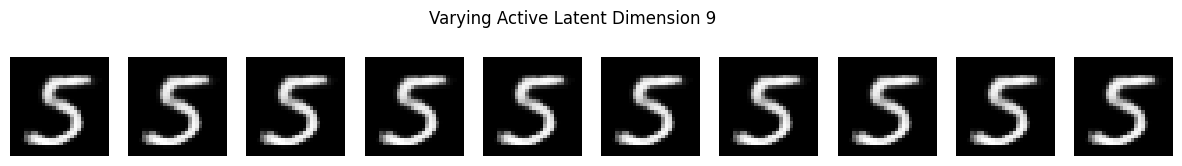

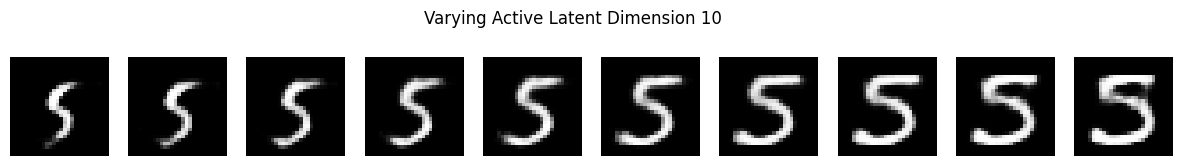

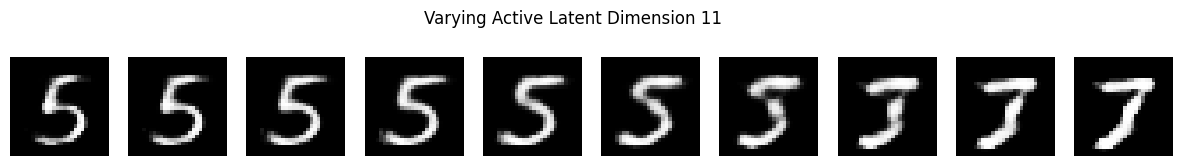

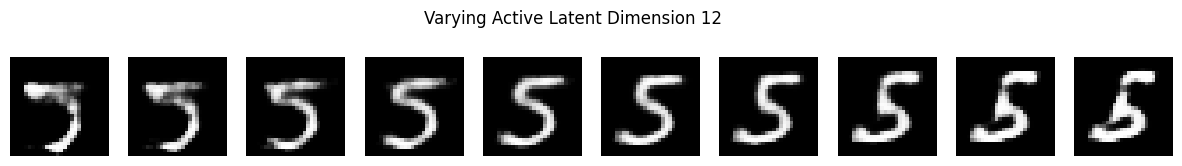

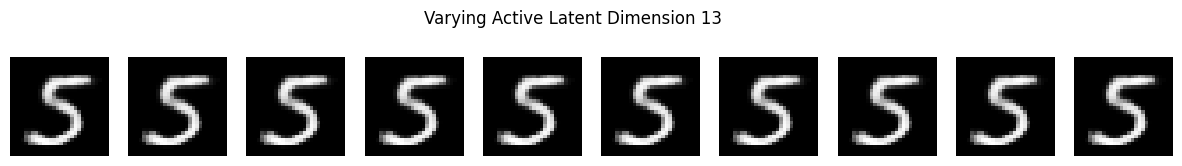

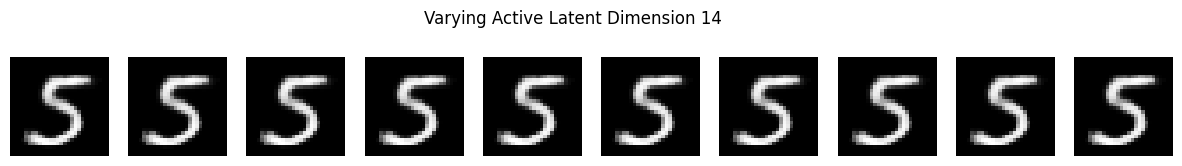

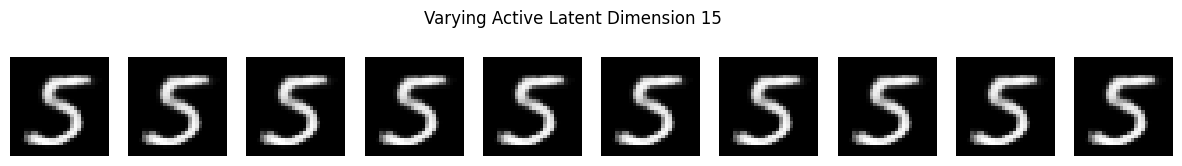

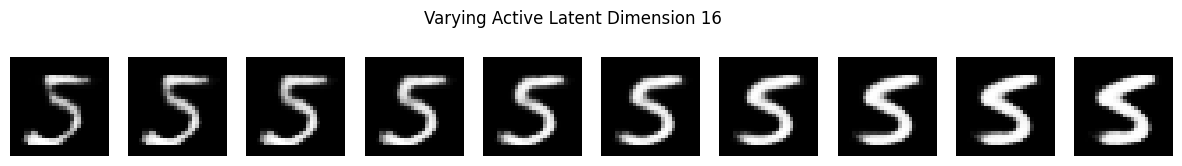

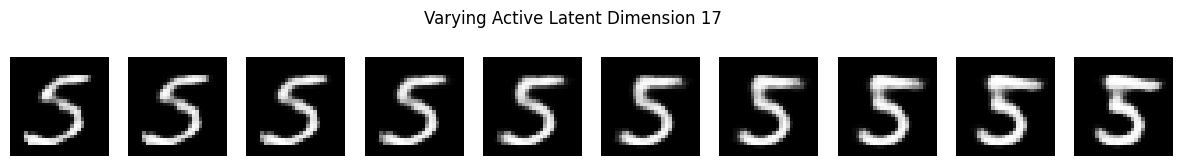

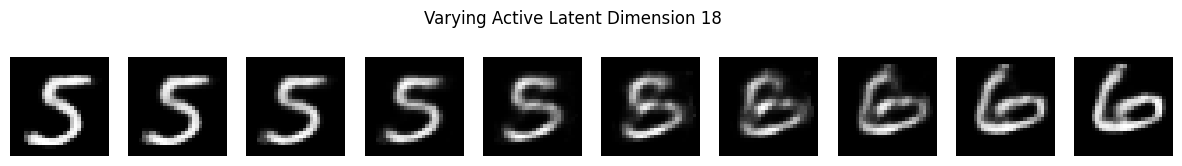

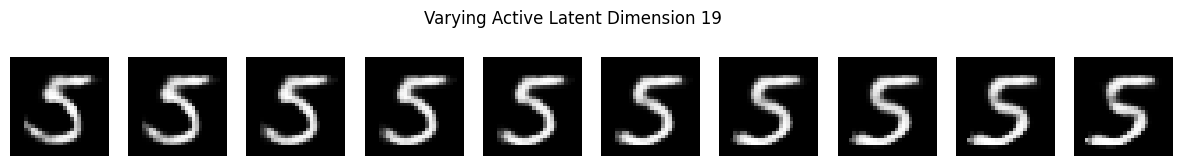

In [59]:
for dim in range(z.size(1)):
    variations = vary_latent_dimension(z, dim_idx=dim, model=model)
    plot_variations(variations, title=f'Varying Active Latent Dimension {dim}')

In [55]:
z.size

<function Tensor.size>